# packages

In [ ]:
import numpy as np
import scipy
import pandas as pd
import pprint
import joblib
from functools import partial
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
import sys
import os
from pathlib import Path
import pickle as pkl
from function_train_xgb import *

# working directory

In [24]:
project_dir = Path("E:/13 Gapfill/gapfill_NEE_U50/")
project_dir.mkdir(exist_ok=True)
site = "AmeriFlux"
site_data_dir = project_dir / site
site_data_dir.mkdir(exist_ok=True)

save_dir = site_data_dir / "xgb_models"
save_dir.mkdir(exist_ok=True)
data_train_test_dir = site_data_dir / "data_train_test"

sys.path.append(site_data_dir)
os.chdir(site_data_dir)
cwd = os.getcwd()
print("Current working directory: ", cwd)
print(site_data_dir)

Current working directory:  E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux
E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux


# input features and targest variable

In [25]:
predictor_subsets = {
        "03_GCC+Base": ['TIMESTAMP_END', 'gcc', 'SWC_1_f', 'SWC_4_f', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos'],
        "02_Base": ['TIMESTAMP_END', 'SWC_1_f', 'SWC_4_f', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos'],
        "05_All": ['TIMESTAMP_END','evi', 'gcc', 'SWC_1_f', 'SWC_4_f', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos'],
        "04_EVI+Base": ['TIMESTAMP_END','evi', 'SWC_1_f', 'SWC_4_f', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos'],
        "01_MDS": ['TIMESTAMP_END', 'Rg_f', 'Tair_f', 'VPD_f', 'DOY_sin', 'DOY_cos'] ,
        "06_top_three": ['TIMESTAMP_END', 'gcc',  'PPFD_DIF', 'PPFD_f', 'DOY_sin', 'DOY_cos']
    }

y_col = 'NEE_U50_orig'

# search space
- reference: https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/
- learning curve: The long flat curves may suggest that the algorithm is learning too fast and we may benefit from slowing it down. Current learning rate: learning_rate=0.045954595736017165. We can try a smaller value, such as 0.01.
- We could repeat the process of decreasing the learning rate and increasing the number of iterations to see if further improvements are possible.
- Another approach to slowing down learning is to add regularization in the form of reducing the number of samples and features (rows and columns) used to construct each tree in the ensemble.
- In this case, we will try halving the number of samples and features respectively via the “subsample” and “colsample_bytree” hyperparameters.

In [10]:
from skopt.space import Real, Integer
search_spaces = {'learning_rate': Real(0.0001, 0.04, 'uniform'), 
                 'max_depth': Integer(2, 20),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization, default = 0
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization, default = 0
                 'n_estimators': Integer(100, 3000), # number of boosting rounds or the number of decision trees
                 'min_child_weight': Real(2, 8, 'uniform'),
                 'gamma': Real(0.1, 0.9, 'uniform') 
}
print(search_spaces)

{'learning_rate': Real(low=0.0001, high=0.04, prior='uniform', transform='identity'), 'max_depth': Integer(low=2, high=20, prior='uniform', transform='identity'), 'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='identity'), 'colsample_bytree': Real(low=0.1, high=1.0, prior='uniform', transform='identity'), 'reg_lambda': Real(low=1e-09, high=100.0, prior='uniform', transform='identity'), 'reg_alpha': Real(low=1e-09, high=100.0, prior='uniform', transform='identity'), 'n_estimators': Integer(low=100, high=3000, prior='uniform', transform='identity'), 'min_child_weight': Real(low=2, high=8, prior='uniform', transform='identity'), 'gamma': Real(low=0.1, high=0.9, prior='uniform', transform='identity')}


# load site data

In [26]:
site_data = pd.read_csv(site_data_dir / "output.csv", index_col=0).dropna(subset=[y_col])
site_data = site_data[site_data['Year'] > 2009]
site_data =  add_time_vars(site_data)

# Step 1: find the best hyperparameters

In [13]:
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

y = site_data[y_col] # target variable

for subset_name, subset_features in predictor_subsets.items():
    model_dir = save_dir / subset_name
    model_dir.mkdir(exist_ok=True, parents=True)

    X = site_data[subset_features] # input features

    # Setting the scoring function
    scoring = make_scorer(partial(mean_squared_error, squared=False), greater_is_better=False)
    
    # 10-fold cv
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_strategy = list(cv.split(X, y))

    # Set up basic regressor: random_state affects sampling data (selecting of the rows), hist
    reg = XGBRegressor(random_state=42, booster='gbtree', objective='reg:squarederror', tree_method='hist')

    # Wrapping everything up into the Bayesian optimizer
    opt = BayesSearchCV(estimator=reg,
                        search_spaces=search_spaces,
                        scoring=scoring,
                        cv=cv_strategy,
                        n_iter=5100,  # max number of trials
                        n_points=20,  # number of hyperparameter sets evaluated at the same time
                        n_jobs=50,  # -1 to use all the available cores
                        iid=False,  # if not iid it optimizes on the cv score
                        return_train_score=False,
                        refit=False,
                        optimizer_kwargs={'base_estimator': 'GP'},  # optimizer parameters: we use Gaussian Process (GP)
                        random_state=42)

    # Running the optimizer
    print('Start to run the optimizer ...')
    overdone_control = DeltaYStopper(delta=0.0001)  # We stop if the gain of the optimization becomes too small
    time_limit_control = DeadlineStopper(total_time=60*60*0.2)  # We impose a time limit (1 hour)

    best_params = report_perf(opt, X, y, 'XGBoost_regression', callbacks=[overdone_control, time_limit_control])
    print(f"Running: best_params={best_params}")

    # Save hyperparameters as CSV
    csv_file = model_dir / 'model_best_params.csv'

    # Write dictionary data to CSV file
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['parameter', 'value'])  # Write header
        for param, value in best_params.items():
            writer.writerow([param, value])
    print(f'Data has been written to {csv_file}')

    # Transferring the best parameters to our basic regressor
    reg = XGBRegressor(random_state=42, booster='gbtree', objective='reg:squarederror', tree_method='hist',
                       **best_params, n_jobs=50)

    # Save model object as pkl
    model_path = model_dir / "model.pkl"
    with open(model_path, 'wb') as f:
        pkl.dump(reg, f)
    print(f"Model pkl files saved to {model_path}.")

Start to run the optimizer ...
XGBoost_regression took 488.67 seconds,  candidates checked: 20, best CV score: -2.503 ± 0.042
Best parameters:
OrderedDict([('colsample_bytree', 0.3794440622617796), ('gamma', 0.8316431360154157), ('learning_rate', 0.03945110716522285), ('max_depth', 8), ('min_child_weight', 3.4639626061936295), ('n_estimators', 1559), ('reg_alpha', 74.93911157534289), ('reg_lambda', 32.31078950191586), ('subsample', 0.5277201321110778)])
Running: best_params=OrderedDict([('colsample_bytree', 0.3794440622617796), ('gamma', 0.8316431360154157), ('learning_rate', 0.03945110716522285), ('max_depth', 8), ('min_child_weight', 3.4639626061936295), ('n_estimators', 1559), ('reg_alpha', 74.93911157534289), ('reg_lambda', 32.31078950191586), ('subsample', 0.5277201321110778)])
Data has been written to E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux\xgb_models\06_top_three\model_best_params.csv
Model pkl files saved to E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux\xgb_models\06_top_

# Step 2: fit/train the model (10 fold CV)
## create new working directory to save data

In [28]:
learning_curve_dir = site_data_dir / "XGB_learning_curve"
learning_curve_dir.mkdir(exist_ok=True)
# test perforamnce
test_performance_dir = site_data_dir / "XGB_test_performance"
test_performance_dir.mkdir(exist_ok=True)
all_prediction_dir = site_data_dir / "XGB_accurate_prediction"
all_prediction_dir.mkdir(exist_ok=True)

# you still need for a better results to compute more metrics
test_prediction_dir = site_data_dir / "XGB_test_prediction"
test_prediction_dir.mkdir(exist_ok=True)
test_prediction_dir

# train performance
train_performance_dir = site_data_dir / "XGB_train_performance"
train_performance_dir.mkdir(exist_ok=True)
print(train_performance_dir)

E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux\XGB_train_performance


## accurate prediction using all data

In [16]:
import pickle as pickle
site_data = pd.read_csv(site_data_dir / "output.csv", index_col=0) # .dropna(subset=[y_col])
site_data_no_na = pd.read_csv(site_data_dir / "output.csv", index_col=0).dropna(subset=[y_col])
site_data = site_data[site_data['Year'] > 2009]
site_data_no_na = site_data_no_na[site_data_no_na['Year'] > 2009]
# site_data =  ftx.add_time_vars(site_data)
site_data =  add_time_vars(site_data)
site_data_no_na =  add_time_vars(site_data_no_na)

for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir / subset_name) / "model.pkl"
    print(model_path)
    with open(model_path, 'rb') as f:
        reg = pickle.load(f)
    print(reg)

    X = site_data_no_na[subset_features]
    y = site_data_no_na[y_col] 
    reg.fit(X, y)

    X_all = site_data[subset_features]
    y_pred = reg.predict(X_all)
    site_data['XGB_NEE_U50_fall'] = y_pred 
    site_data['XGB_NEE_U50_f'] = np.where(site_data[y_col].notnull(), site_data[y_col], site_data['XGB_NEE_U50_fall'])
    site_data.to_csv(all_prediction_dir / (subset_name + '_all_prediction.csv'))

06_top_three
E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux\xgb_models\06_top_three\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3794440622617796, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.8316431360154157, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03945110716522285, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3.4639626061936295, missing=nan,
             monotone_constraints=None, n_estimators=1559, n_jobs=50,
             num_parallel_tree=None, predictor=None, random_state=42, ...)


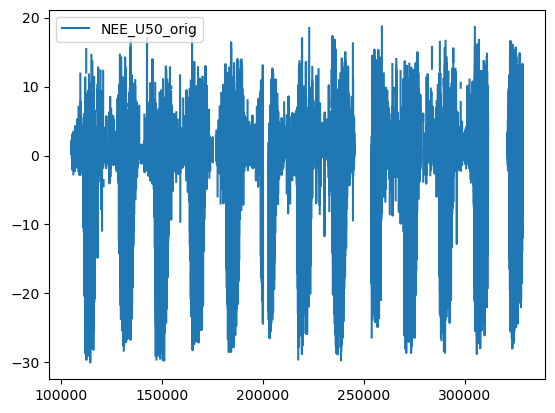

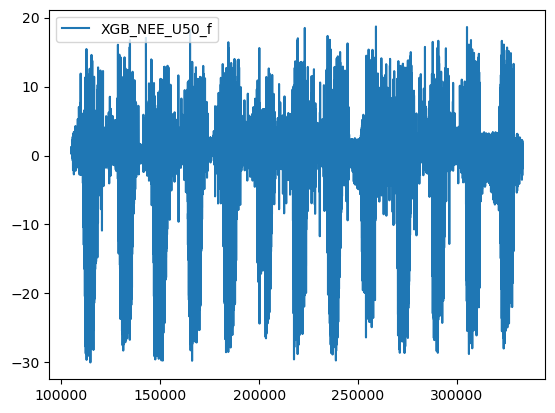

In [18]:
# Plot 'NEE_U50_orig' and 'XGB_NEE_U50_f' respectively
plt.plot(site_data['NEE_U50_orig'], label='NEE_U50_orig')
plt.legend()
plt.show()
plt.plot(site_data['XGB_NEE_U50_f'], label='XGB_NEE_U50_f')
plt.legend()
plt.show()

# Step 3:  model performance (10 test set)

E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux\data_train_test
06_top_three
E:\13 Gapfill\gapfill_NEE_50_repeat\AmeriFlux\xgb_models\06_top_three\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3794440622617796, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.8316431360154157, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03945110716522285, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3.4639626061936295, missing=nan,
             monotone_constraints=None, n_estimators=1559, n_jobs=50,
             num_parallel_tree=None, predictor=None, random_state=42, ...)
[0]	validation_0-rmse:7.83589	valida

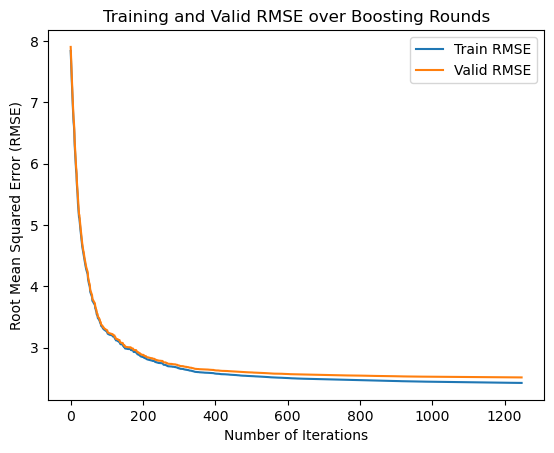

[0]	validation_0-rmse:7.83964	validation_1-rmse:7.87807
[1]	validation_0-rmse:7.66496	validation_1-rmse:7.70484
[2]	validation_0-rmse:7.51485	validation_1-rmse:7.55371
[3]	validation_0-rmse:7.35878	validation_1-rmse:7.39827
[4]	validation_0-rmse:7.20474	validation_1-rmse:7.24531
[5]	validation_0-rmse:7.05264	validation_1-rmse:7.09458
[6]	validation_0-rmse:6.92121	validation_1-rmse:6.96377
[7]	validation_0-rmse:6.79641	validation_1-rmse:6.83785
[8]	validation_0-rmse:6.67656	validation_1-rmse:6.71692
[9]	validation_0-rmse:6.61394	validation_1-rmse:6.65257
[10]	validation_0-rmse:6.49893	validation_1-rmse:6.53844
[11]	validation_0-rmse:6.30786	validation_1-rmse:6.34756
[12]	validation_0-rmse:6.20338	validation_1-rmse:6.24394
[13]	validation_0-rmse:6.08816	validation_1-rmse:6.13031
[14]	validation_0-rmse:5.98275	validation_1-rmse:6.02616
[15]	validation_0-rmse:5.88480	validation_1-rmse:5.93028
[16]	validation_0-rmse:5.83895	validation_1-rmse:5.88282
[17]	validation_0-rmse:5.67520	validation

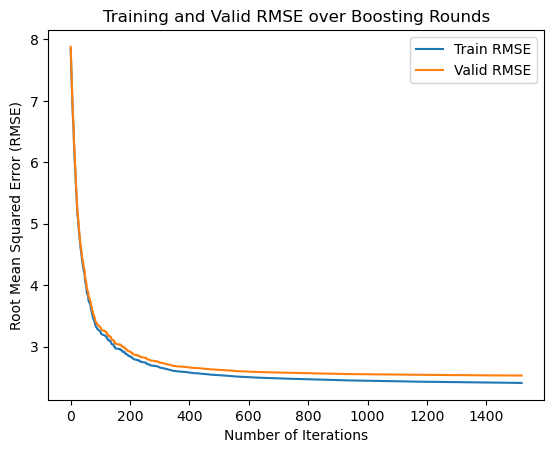

[0]	validation_0-rmse:7.84881	validation_1-rmse:7.79922
[1]	validation_0-rmse:7.67440	validation_1-rmse:7.62344
[2]	validation_0-rmse:7.52316	validation_1-rmse:7.47121
[3]	validation_0-rmse:7.36790	validation_1-rmse:7.31664
[4]	validation_0-rmse:7.21312	validation_1-rmse:7.16044
[5]	validation_0-rmse:7.06043	validation_1-rmse:7.00801
[6]	validation_0-rmse:6.92860	validation_1-rmse:6.87676
[7]	validation_0-rmse:6.80347	validation_1-rmse:6.75039
[8]	validation_0-rmse:6.68463	validation_1-rmse:6.63038
[9]	validation_0-rmse:6.62095	validation_1-rmse:6.56468
[10]	validation_0-rmse:6.50555	validation_1-rmse:6.44975
[11]	validation_0-rmse:6.31428	validation_1-rmse:6.25811
[12]	validation_0-rmse:6.20975	validation_1-rmse:6.15470
[13]	validation_0-rmse:6.09364	validation_1-rmse:6.03838
[14]	validation_0-rmse:5.97657	validation_1-rmse:5.92180
[15]	validation_0-rmse:5.87837	validation_1-rmse:5.82260
[16]	validation_0-rmse:5.83292	validation_1-rmse:5.77577
[17]	validation_0-rmse:5.66971	validation

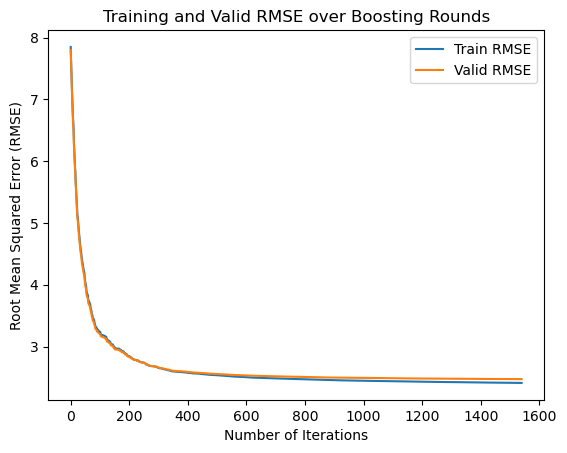

[0]	validation_0-rmse:7.85263	validation_1-rmse:7.76824
[1]	validation_0-rmse:7.67886	validation_1-rmse:7.59661
[2]	validation_0-rmse:7.52748	validation_1-rmse:7.44682
[3]	validation_0-rmse:7.37149	validation_1-rmse:7.29059
[4]	validation_0-rmse:7.21697	validation_1-rmse:7.13898
[5]	validation_0-rmse:7.06484	validation_1-rmse:6.98633
[6]	validation_0-rmse:6.93292	validation_1-rmse:6.85429
[7]	validation_0-rmse:6.80752	validation_1-rmse:6.72959
[8]	validation_0-rmse:6.68855	validation_1-rmse:6.61221
[9]	validation_0-rmse:6.62446	validation_1-rmse:6.54904
[10]	validation_0-rmse:6.50947	validation_1-rmse:6.43433
[11]	validation_0-rmse:6.31895	validation_1-rmse:6.24690
[12]	validation_0-rmse:6.21479	validation_1-rmse:6.14257
[13]	validation_0-rmse:6.09922	validation_1-rmse:6.02970
[14]	validation_0-rmse:5.99548	validation_1-rmse:5.92627
[15]	validation_0-rmse:5.89605	validation_1-rmse:5.82910
[16]	validation_0-rmse:5.84488	validation_1-rmse:5.77886
[17]	validation_0-rmse:5.68025	validation

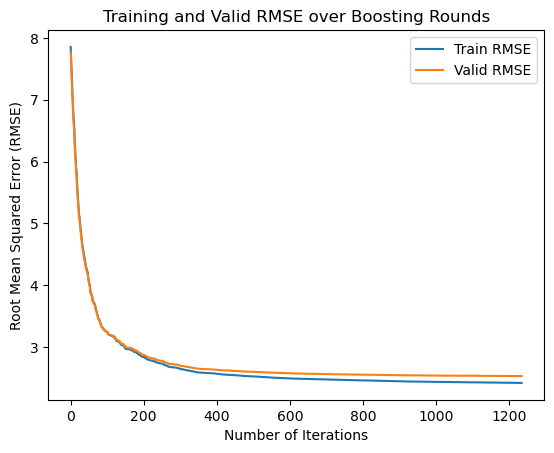

[0]	validation_0-rmse:7.84793	validation_1-rmse:7.80859
[1]	validation_0-rmse:7.67298	validation_1-rmse:7.63460
[2]	validation_0-rmse:7.52158	validation_1-rmse:7.48378
[3]	validation_0-rmse:7.36537	validation_1-rmse:7.32939
[4]	validation_0-rmse:7.21007	validation_1-rmse:7.17495
[5]	validation_0-rmse:7.05770	validation_1-rmse:7.02579
[6]	validation_0-rmse:6.92485	validation_1-rmse:6.89424
[7]	validation_0-rmse:6.79882	validation_1-rmse:6.76869
[8]	validation_0-rmse:6.67891	validation_1-rmse:6.64940
[9]	validation_0-rmse:6.61576	validation_1-rmse:6.58688
[10]	validation_0-rmse:6.50121	validation_1-rmse:6.47367
[11]	validation_0-rmse:6.31102	validation_1-rmse:6.28390
[12]	validation_0-rmse:6.20694	validation_1-rmse:6.18143
[13]	validation_0-rmse:6.09148	validation_1-rmse:6.06796
[14]	validation_0-rmse:5.97611	validation_1-rmse:5.95534
[15]	validation_0-rmse:5.87786	validation_1-rmse:5.85753
[16]	validation_0-rmse:5.83299	validation_1-rmse:5.81329
[17]	validation_0-rmse:5.66992	validation

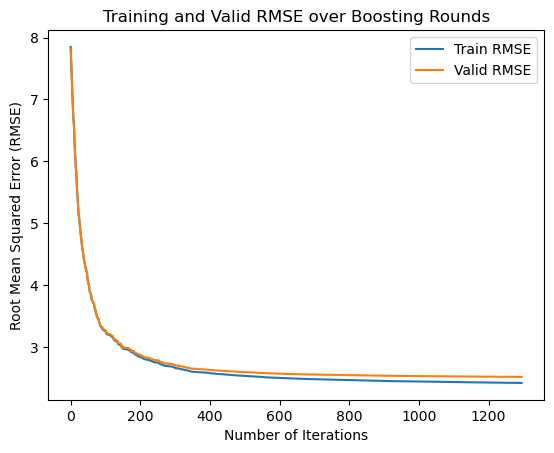

[0]	validation_0-rmse:7.83691	validation_1-rmse:7.91590
[1]	validation_0-rmse:7.66242	validation_1-rmse:7.74127
[2]	validation_0-rmse:7.51206	validation_1-rmse:7.58779
[3]	validation_0-rmse:7.35719	validation_1-rmse:7.42956
[4]	validation_0-rmse:7.20244	validation_1-rmse:7.27449
[5]	validation_0-rmse:7.05144	validation_1-rmse:7.12112
[6]	validation_0-rmse:6.91943	validation_1-rmse:6.98565
[7]	validation_0-rmse:6.79440	validation_1-rmse:6.85782
[8]	validation_0-rmse:6.67671	validation_1-rmse:6.73693
[9]	validation_0-rmse:6.61397	validation_1-rmse:6.67196
[10]	validation_0-rmse:6.49893	validation_1-rmse:6.55373
[11]	validation_0-rmse:6.30926	validation_1-rmse:6.36141
[12]	validation_0-rmse:6.20608	validation_1-rmse:6.25513
[13]	validation_0-rmse:6.09030	validation_1-rmse:6.13752
[14]	validation_0-rmse:5.98282	validation_1-rmse:6.02748
[15]	validation_0-rmse:5.88488	validation_1-rmse:5.92928
[16]	validation_0-rmse:5.83906	validation_1-rmse:5.88155
[17]	validation_0-rmse:5.67486	validation

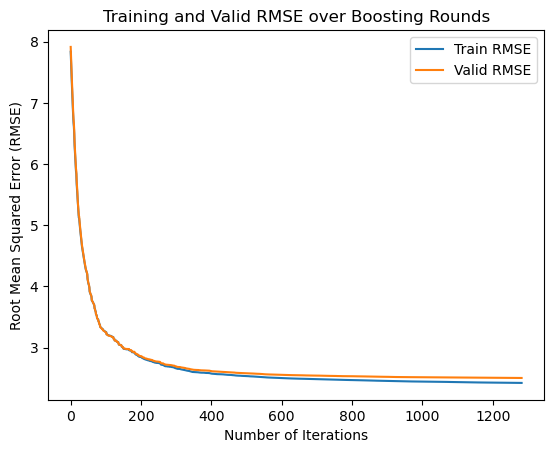

[0]	validation_0-rmse:7.84077	validation_1-rmse:7.87125
[1]	validation_0-rmse:7.66579	validation_1-rmse:7.69429
[2]	validation_0-rmse:7.51647	validation_1-rmse:7.54635
[3]	validation_0-rmse:7.36046	validation_1-rmse:7.39164
[4]	validation_0-rmse:7.20620	validation_1-rmse:7.23573
[5]	validation_0-rmse:7.05201	validation_1-rmse:7.08241
[6]	validation_0-rmse:6.92002	validation_1-rmse:6.95155
[7]	validation_0-rmse:6.79512	validation_1-rmse:6.82787
[8]	validation_0-rmse:6.67581	validation_1-rmse:6.71052
[9]	validation_0-rmse:6.61400	validation_1-rmse:6.64893
[10]	validation_0-rmse:6.49928	validation_1-rmse:6.53509
[11]	validation_0-rmse:6.30813	validation_1-rmse:6.34546
[12]	validation_0-rmse:6.20458	validation_1-rmse:6.24241
[13]	validation_0-rmse:6.08920	validation_1-rmse:6.12645
[14]	validation_0-rmse:5.98411	validation_1-rmse:6.02137
[15]	validation_0-rmse:5.88608	validation_1-rmse:5.92219
[16]	validation_0-rmse:5.83967	validation_1-rmse:5.87626
[17]	validation_0-rmse:5.67508	validation

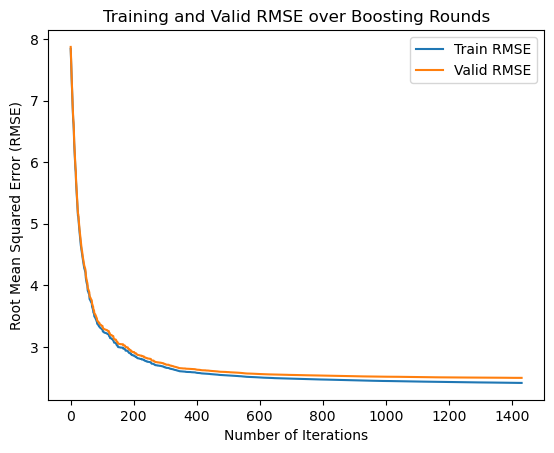

[0]	validation_0-rmse:7.84872	validation_1-rmse:7.80271
[1]	validation_0-rmse:7.67378	validation_1-rmse:7.62834
[2]	validation_0-rmse:7.52139	validation_1-rmse:7.47744
[3]	validation_0-rmse:7.36547	validation_1-rmse:7.32217
[4]	validation_0-rmse:7.21048	validation_1-rmse:7.16790
[5]	validation_0-rmse:7.05805	validation_1-rmse:7.01687
[6]	validation_0-rmse:6.92580	validation_1-rmse:6.88571
[7]	validation_0-rmse:6.79928	validation_1-rmse:6.76127
[8]	validation_0-rmse:6.68011	validation_1-rmse:6.64376
[9]	validation_0-rmse:6.61093	validation_1-rmse:6.57724
[10]	validation_0-rmse:6.49572	validation_1-rmse:6.46349
[11]	validation_0-rmse:6.30518	validation_1-rmse:6.27478
[12]	validation_0-rmse:6.20102	validation_1-rmse:6.17143
[13]	validation_0-rmse:6.08602	validation_1-rmse:6.05788
[14]	validation_0-rmse:5.97554	validation_1-rmse:5.94870
[15]	validation_0-rmse:5.87708	validation_1-rmse:5.85116
[16]	validation_0-rmse:5.82910	validation_1-rmse:5.80615
[17]	validation_0-rmse:5.66603	validation

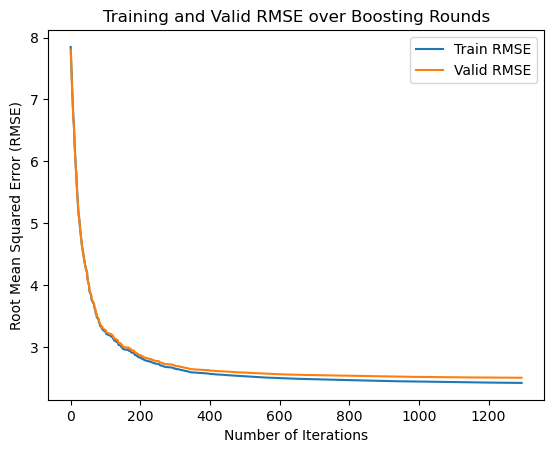

[0]	validation_0-rmse:7.84835	validation_1-rmse:7.79696
[1]	validation_0-rmse:7.67286	validation_1-rmse:7.62163
[2]	validation_0-rmse:7.52187	validation_1-rmse:7.47259
[3]	validation_0-rmse:7.36691	validation_1-rmse:7.31957
[4]	validation_0-rmse:7.21212	validation_1-rmse:7.16475
[5]	validation_0-rmse:7.05927	validation_1-rmse:7.01444
[6]	validation_0-rmse:6.92703	validation_1-rmse:6.88422
[7]	validation_0-rmse:6.80242	validation_1-rmse:6.76192
[8]	validation_0-rmse:6.68170	validation_1-rmse:6.64267
[9]	validation_0-rmse:6.61618	validation_1-rmse:6.57797
[10]	validation_0-rmse:6.50065	validation_1-rmse:6.46438
[11]	validation_0-rmse:6.31018	validation_1-rmse:6.27547
[12]	validation_0-rmse:6.20560	validation_1-rmse:6.17286
[13]	validation_0-rmse:6.09055	validation_1-rmse:6.05921
[14]	validation_0-rmse:5.97907	validation_1-rmse:5.94957
[15]	validation_0-rmse:5.88110	validation_1-rmse:5.85188
[16]	validation_0-rmse:5.83630	validation_1-rmse:5.80681
[17]	validation_0-rmse:5.67277	validation

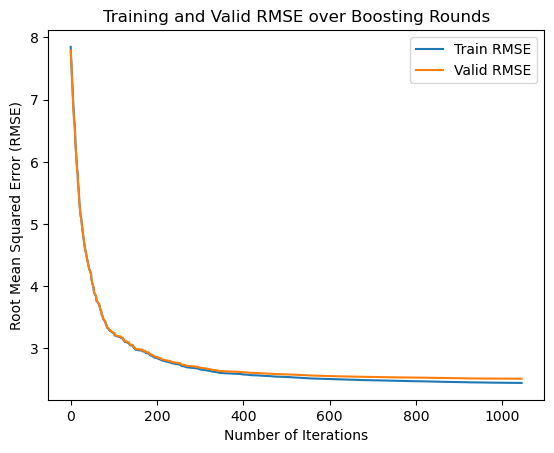

[0]	validation_0-rmse:7.83901	validation_1-rmse:7.89437
[1]	validation_0-rmse:7.66360	validation_1-rmse:7.71958
[2]	validation_0-rmse:7.51262	validation_1-rmse:7.56838
[3]	validation_0-rmse:7.35778	validation_1-rmse:7.41154
[4]	validation_0-rmse:7.20329	validation_1-rmse:7.25727
[5]	validation_0-rmse:7.05372	validation_1-rmse:7.10526
[6]	validation_0-rmse:6.92249	validation_1-rmse:6.97191
[7]	validation_0-rmse:6.79693	validation_1-rmse:6.84647
[8]	validation_0-rmse:6.67833	validation_1-rmse:6.72763
[9]	validation_0-rmse:6.61433	validation_1-rmse:6.66549
[10]	validation_0-rmse:6.49960	validation_1-rmse:6.54888
[11]	validation_0-rmse:6.30975	validation_1-rmse:6.35619
[12]	validation_0-rmse:6.20602	validation_1-rmse:6.25054
[13]	validation_0-rmse:6.09083	validation_1-rmse:6.13403
[14]	validation_0-rmse:5.98283	validation_1-rmse:6.02492
[15]	validation_0-rmse:5.88477	validation_1-rmse:5.92608
[16]	validation_0-rmse:5.83811	validation_1-rmse:5.88043
[17]	validation_0-rmse:5.67389	validation

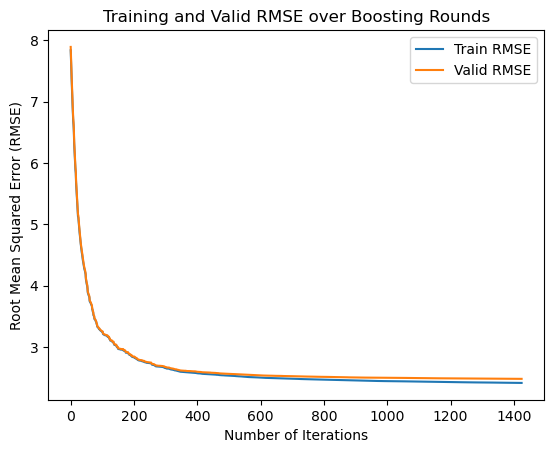

In [15]:
import pickle
import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
print(data_train_test_dir)
for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir / subset_name) / "model.pkl"
    print(model_path)

    with open(model_path, 'rb') as f:
        reg = pickle.load(f)
    print(reg)

    # 10 fold model evaluation
    for i in range(1,11):
        train = pd.read_csv(data_train_test_dir / f"train{i}.csv", index_col=0).dropna(subset=[y_col])
        test = pd.read_csv(data_train_test_dir / f"test{i}.csv", index_col=0).dropna(subset=[y_col])
        train = add_time_vars(train)
        X_train = train[subset_features]
        y_train = train[y_col]
        test = add_time_vars(test)
        X_test = test[subset_features]
        y_test = test[y_col]
        
        # X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)
        results = reg.evals_result()
        plt.plot(results['validation_0']['rmse'], label='Train RMSE')
        plt.plot(results['validation_1']['rmse'], label='Valid RMSE')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Root Mean Squared Error (RMSE)')
        plt.legend()
        plt.title('Training and Valid RMSE over Boosting Rounds')
        plt.savefig(learning_curve_dir / (subset_name + f'_learning_curve{i}.png'))
        plt.show()
        
        # test performance
        y_test_pred = reg.predict(X_test)
        scores = compute_performance_metrics(y_test, y_test_pred)
        scores_df = pd.DataFrame(scores, index=[0])
        scores_df.to_csv(test_performance_dir / (subset_name + f"_test_performance{i}.csv"), index=False)

        # test prediction
        test['XGB_NEE_U50_fall'] = y_test_pred
        test['XGB_NEE_U50_f'] = np.where(test[y_col].notnull(), test[y_col], test['XGB_NEE_U50_fall'])
        test.to_csv(test_prediction_dir / (subset_name + f"_test_prediction{i}.csv"), index=False)

## Step 3: model performance on test set (10 fold CV)

In [13]:
import pickle
print(data_train_test_dir)
for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir / subset_name) / "model.pkl"
    print(model_path)

    with open(model_path, 'rb') as f:
        reg = pickle.load(f)
    print(reg)

    # 10 fold model evaluation
    for i in range(1,11):
        train = pd.read_csv(data_train_test_dir / f"train{i}.csv", index_col=0).dropna(subset=[y_col])
        test = pd.read_csv(data_train_test_dir / f"test{i}.csv", index_col=0).dropna(subset=[y_col])
        train = add_time_vars(train)
        X_train = train[subset_features]
        y_train = train[y_col]
        test = add_time_vars(test)
        X_test = test[subset_features]
        y_test = test[y_col]
       
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20)
        
        # test performance
        y_test_pred = reg.predict(X_test)
        scores = compute_performance_metrics(y_test, y_test_pred)
        scores_df = pd.DataFrame(scores, index=[0])
        scores_df.to_csv(test_performance_dir / (subset_name + f"_test_performance{i}.csv"), index=False)

        # test prediction
        test['XGB_NEE_U50_fall'] = y_test_pred
        test['XGB_NEE_U50_f'] = np.where(test[y_col].notnull(), test[y_col], test['XGB_NEE_U50_fall'])
        test.to_csv(test_prediction_dir / (subset_name + f"_test_prediction{i}.csv"), index=False)

E:\13 Gapfill\gapfill_NEE_50_best_hyperparameter\AmeriFlux\data_train_test
03_GCC+Base
E:\13 Gapfill\gapfill_NEE_50_best_hyperparameter\AmeriFlux\xgb_models\03_GCC+Base\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.46909356296798244, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.6821805945418601, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.037321433154028576, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=6.020887689613608, missing=nan,
             monotone_constraints=None, n_estimators=1301, n_jobs=50,
             num_parallel_tree=None, predictor=None, random_state=42, ...)
[0]	validat


# Step 4: Feature importance

In [17]:
import pickle as pickle
site_data = pd.read_csv(site_data_dir / "site_data_AmeriFlux.csv", index_col=0) # .dropna(subset=[y_col])
site_data_no_na = pd.read_csv(site_data_dir / "site_data_AmeriFlux.csv", index_col=0).dropna(subset=[y_col])
site_data = site_data[site_data['Year'] > 2009]
site_data_no_na = site_data_no_na[site_data_no_na['Year'] > 2009]
site_data =  add_time_vars(site_data)
site_data_no_na =  add_time_vars(site_data_no_na)

y_col = 'NEE_U50_orig'
subset_features = ['TIMESTAMP_END','evi', 'gcc', 'SWC_1_f', 'SWC_4_f', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos']
subset_name = "05_All"
feature_importance_df = pd.DataFrame()
import pickle   
model_path = (save_dir / subset_name) / "model.pkl"  
with open(model_path, 'rb') as f:
    reg = pickle.load(f)

X = site_data_no_na[subset_features]
y = site_data_no_na[y_col] 
reg.fit(X, y)
feature_importance_df['Feature_Importances'] = reg.feature_importances_
print(feature_importance_df)
feature_importance_df.to_csv(site_data_dir / "feature_importances_all_predictors.csv", index=False)